In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from fracdiff import Fracdiff, StationaryFracdiff

seaborn.set_style('ticks')

In [2]:
np.random.seed(42)

In [3]:
from statsmodels.tsa.stattools import adfuller

def adf_test(array):
    """Carry out ADF unit-root test and print the result."""
    adf, pvalue, _, _, _, _ = adfuller(array)
    print(f'ADF statistics: {adf:.3f}')
    print(f'ADF p-value: {pvalue:.3f}')

## 5.1

- Prepare Gaussian, its cumsum and its differentiation.

In [4]:
T = 1000

gauss = np.random.randn(T)
brown = gauss.cumsum()
overd = np.diff(gauss)

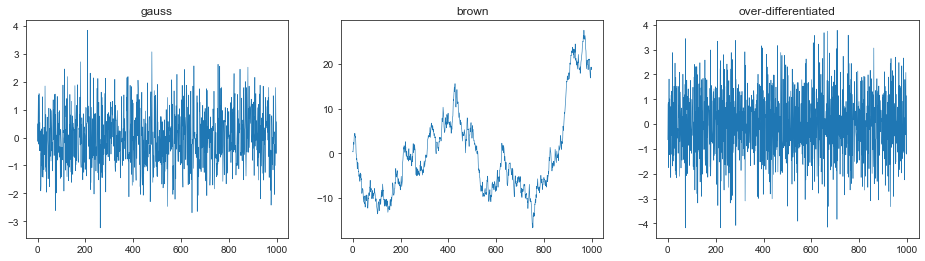

In [5]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.title('gauss')
plt.plot(gauss, linewidth=0.6)

plt.subplot(1, 3, 2)
plt.title('brown')
plt.plot(brown, linewidth=0.6)

plt.subplot(1, 3, 3)
plt.title('over-differentiated')
plt.plot(overd, linewidth=0.6)

plt.show()

### 5.1 (a)

In [6]:
adf_test(gauss)

ADF statistics: -31.811
ADF p-value: 0.000


### 5.1 (b)

- Order of integration of cumsum is 1.

In [7]:
adf_test(brown)

ADF statistics: -0.966
ADF p-value: 0.765


### 5.1 (c)

- ADF statistics and p-value of over-differentiated process are:

In [8]:
adf_test(overd)

ADF statistics: -11.486
ADF p-value: 0.000


## 5.2

- Prepare `sin` function and the process given by `(sin + shift).cumsum()` (which we call `hop`):

In [9]:
T = 1000
shift = 0.1

sin = np.sin(np.linspace(0, 10 * np.pi, T))
hop = (sin + shift).cumsum()

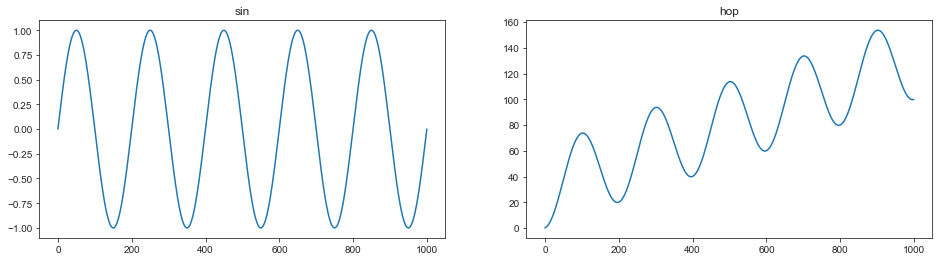

In [10]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.title('sin')
plt.plot(sin)

plt.subplot(1, 2, 2)
plt.title(f'hop')
plt.plot(hop)

plt.show()

### 5.2 (a)

In [11]:
adf_test(sin)

ADF statistics: -13323341825676.293
ADF p-value: 0.000


### 5.2 (b)

In [12]:
adf_test(hop)

ADF statistics: -0.415
ADF p-value: 0.908


- Let us see ADF p-values of fracdiff of `hop` with various orders:
- Notice: We will use the fixed-window method instead of expanding window method.

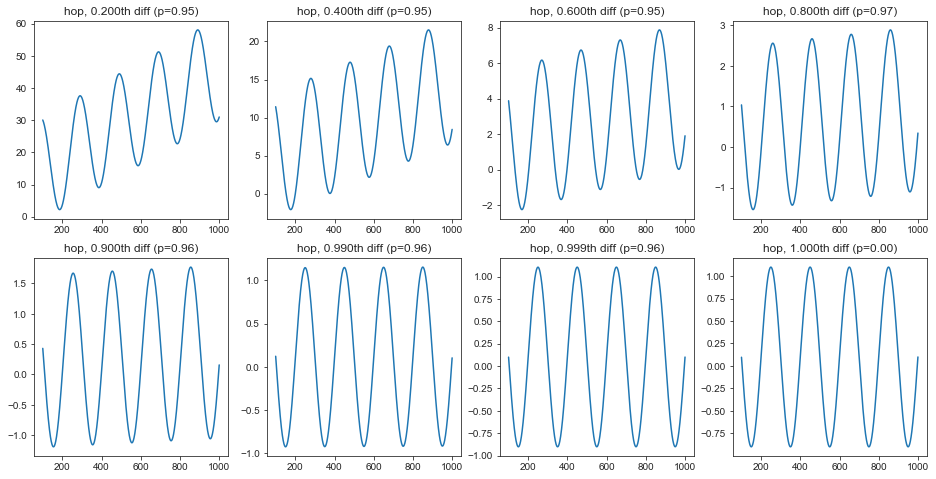

In [13]:
orders = (
    0.200, 0.400, 0.600, 0.800,
    0.900, 0.990, 0.999, 1.000,
)
window = 100

X = hop.reshape(-1, 1)

plt.figure(figsize=(16, 8))
for i, order in enumerate(orders):
    Xd = Fracdiff(order, window=window).transform(X)
    _, pvalue, _, _, _, _ = adfuller(Xd[window:, 0])
    
    plt.subplot(2, 4, i + 1)
    plt.title(f'hop, {order:.3f}th diff (p={pvalue:.2f})')
    plt.plot(Xd)

- It seems that the minimum order lies pretty close to `1.0`.
- Let us search the minimum using `StationaryFracdiff`. The result reads:

In [14]:
statfracdiff = StationaryFracdiff(window=window, precision=10e-8, lower=0.9)

Xd = statfracdiff.fit_transform(X)
order = statfracdiff.order_[0]

print(f'Order: {order:.8f}')
adf_test(Xd[window:, 0])

Order: 0.99999990
ADF statistics: -851834847.328
ADF p-value: 0.000


In [15]:
# Check
Xd_ = Fracdiff(order - 10e-8).transform(X)

print(f'Order: {order - 10e-8:.8f}')
adf_test(Xd_[window:, 0])

Order: 0.99999980
ADF statistics: 0.000
ADF p-value: 0.959


- Differentiated time-series looks like this:

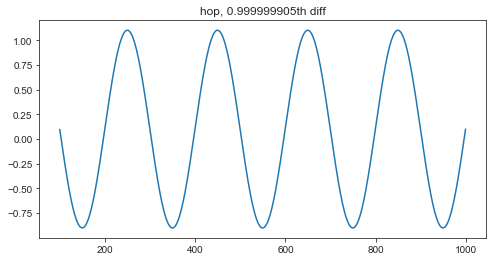

In [16]:
plt.figure(figsize=(8, 4))
plt.plot(Xd)
plt.title(f'hop, {order:.9f}th diff')
plt.show()

## 5.3

### 5.3 (a)

In [17]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(sin.reshape(-1, 1), hop)

print(f'R-squared: {linreg.score(sin.reshape(-1, 1), hop):.4f}')

R-squared: 0.0128


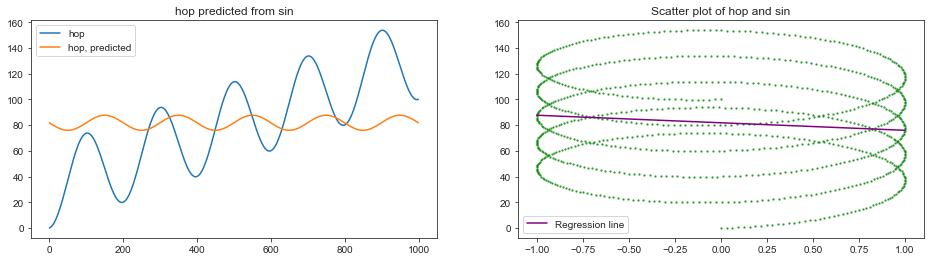

In [18]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 2, 1)
plt.title('hop predicted from sin')
plt.plot(hop, label='hop')
plt.plot(linreg.predict(sin.reshape(-1, 1)), label='hop, predicted')
plt.legend()

plt.subplot(1,2,2)
plt.title('Scatter plot of hop and sin')
x = np.linspace(-1, 1, 2)
y = linreg.predict(x.reshape(-1, 1))
plt.scatter(sin, hop, s=2, alpha=0.6, color='green')
plt.plot(x, y, color='purple', label='Regression line')
plt.legend()

plt.show()

### 5.3 (b)

In [19]:
window = 100

hopd = Fracdiff(1.0, window=window).transform(hop.reshape(-1, 1))

linreg = LinearRegression()
linreg.fit(sin.reshape(-1, 1)[window:], hopd[window:, 0])

print(f'Coefficient: {linreg.coef_[0]}')
print(f'Intercept: {linreg.intercept_}')
print(f'R-squared: {linreg.score(sin.reshape(-1, 1)[window:], hopd[window:]):.4f}')

Coefficient: 1.0
Intercept: 0.1
R-squared: 1.0000


### 5.3 (c)

- `d=1`. Because 1st order differentiation of `hop` is `sin` plus a constant.

## 5.4

- NOTE: We will use time-bar instead of dollar-bar.

In [20]:
import pandas_datareader
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

def fetch_spx():
    return pandas_datareader.data.DataReader(
        '^GSPC', 'yahoo', '1998-01-01', '2018-12-31'
    )['Adj Close']

spx = fetch_spx()

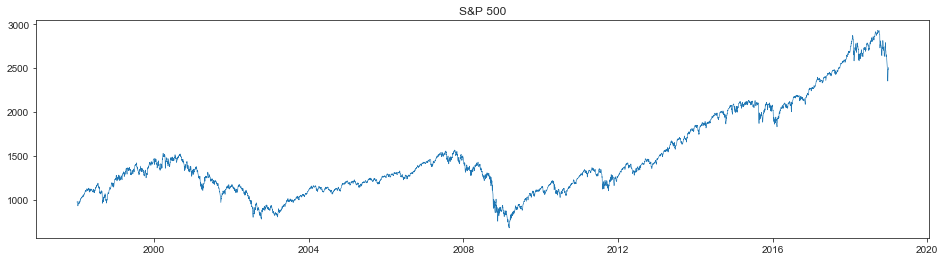

In [21]:
plt.figure(figsize=(16, 4))
plt.plot(spx, linewidth=0.6)
plt.title('S&P 500')
plt.show()

In [22]:
order = 0.2
window = 100

X = spx.values.reshape(-1, 1)

Xd = Fracdiff(order, window=window).transform(X)[window:]
Xi = Fracdiff(-order, window=window).transform(Xd)[window:]

spxd = pd.Series(Xd[window:, 0], index=spx.index[2 * window:])
spxi = pd.Series(Xi[:, 0], index=spx.index[2 * window:])

- What we get is, in principle, the original time-series plus some constant.
- While there are small numerical errors due to the cut-off of a sequence of coefficients with a finite window.

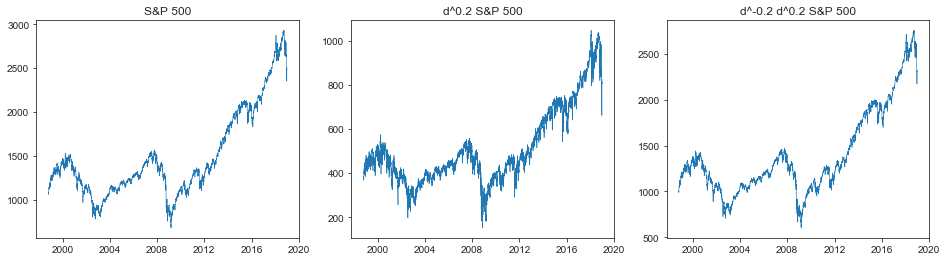

In [23]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.title('S&P 500')
plt.plot(spx[2 * window:], linewidth=0.6)

plt.subplot(1, 3, 2)
plt.title(f'd^{order} S&P 500')
plt.plot(spxd, linewidth=0.6)

plt.subplot(1, 3, 3)
plt.title(f'd^{-order} d^{order} S&P 500')
plt.plot(spxi, linewidth=0.6)

plt.show()

## 5.5

### 5.5 (a)

In [24]:
spxlogcumsum = spx.apply(np.log).cumsum()

### 5.5 (b)

In [25]:
spxlog = spx.apply(np.log)  # = d^1 spxlogcumsum

X = spxlog.values.reshape(-1, 1)

In [26]:
window = 100

statfracdiff = StationaryFracdiff(window=window, lower=0.0, upper=1.0)
Xd = statfracdiff.fit_transform(X)

spxd = pd.Series(Xd[window:, 0], index=spx.index[window:])

In [27]:
order = statfracdiff.order_[0]

print(f'Order: {1 + order:.2f}')  # Answer

Order: 1.42


In [28]:
adf_test(Xd[window:,0])  # Check stationarity

ADF statistics: -2.885
ADF p-value: 0.047


### 5.5 (c)

In [29]:
corr = np.corrcoef(X[window:, 0], Xd[window:, 0])[0, 1]

print(f'Correlation: {corr:.2f}')

Correlation: 0.90


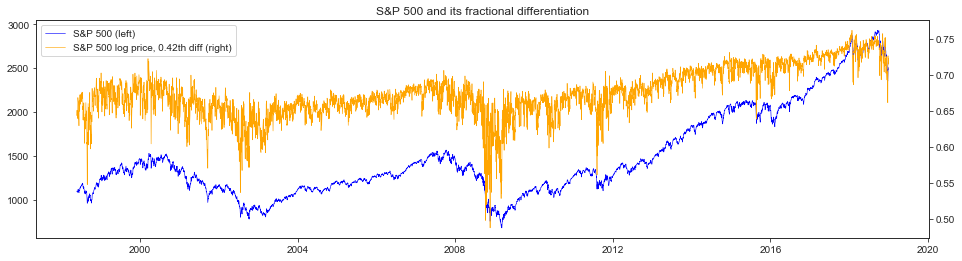

In [30]:
fig, ax_spx = plt.subplots(figsize=(16, 4))
ax_spxd = ax_spx.twinx()

plot_spx = ax_spx.plot(
    spx[window:], color='blue', linewidth=0.6,
    label='S&P 500 (left)'
)
plot_spxd = ax_spxd.plot(
    spxd, color='orange', linewidth=0.6,
    label=f'S&P 500 log price, {statfracdiff.order_[0]:.2f}th diff (right)'
)
plots = plot_spx + plot_spxd
labels = [plot.get_label() for plot in plots]

plt.title('S&P 500 and its fractional differentiation')
ax_spx.legend(plots, labels, loc=0)

plt.show()

### 5.5 (d)

- It is nonsense to discuss cointegration of `Xd` because cointegration is defined among non-stationary processes and `Xd` is stationary.
- So we will instead discuss cointegration between 1.4th differentiated time-series, which is non-stationary, with the original time-series.

In [31]:
order_ = 0.4

Xd_ = Fracdiff(order_, window=window).transform(X)

adf_test(Xd_[window:, 0])  # Check non-stationarity

ADF statistics: -2.669
ADF p-value: 0.080


In [32]:
from cointanalysis import CointAnalysis

pair = np.hstack([X, Xd_])[window:]

ca = CointAnalysis().test(pair)
print(f'AEG statistics: {ca.stat_:.2f}')
print(f'AEG p-value: {ca.pvalue_:.2e}')

AEG statistics: -6.18
AEG p-value: 6.50e-07


- They are cointegrated.
- Rough reason: For `d=0`, two series are exactly the same and so trivially cointegrated. For `d` that is close to the minimum value to make fracdiff stationary, one can make an almost stationary series by adding the original series multiplied by an infinitesimally small coefficient to fracdiff. One can expect cointegration for any `d` in between assuming an interpolation.

In [33]:
ca.fit(pair)

Y = - X * ca.coef_[0]
Yd_ = Xd_ * ca.coef_[1] - ca.mean_

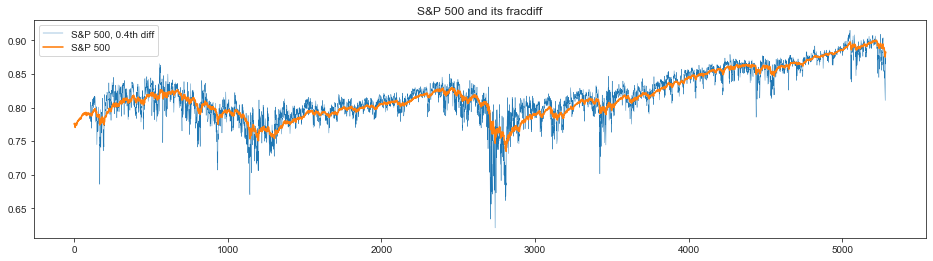

In [34]:
plt.figure(figsize=(16, 4))

plt.plot(Yd_, linewidth=0.4, label=f'S&P 500, {order_}th diff')
plt.plot(Y, linewidth=1.6, label='S&P 500')

plt.legend()
plt.title('S&P 500 and its fracdiff')
plt.show()

In [35]:
spread = ca.transform(pair)

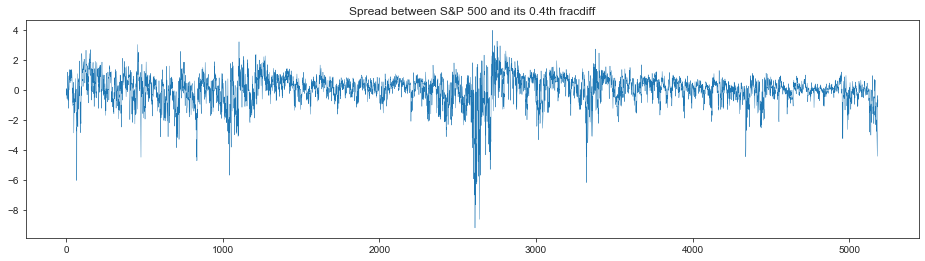

In [36]:
plt.figure(figsize=(16, 4))

plt.plot(spread, linewidth=0.4)

plt.title(f'Spread between S&P 500 and its {order_}th fracdiff')
plt.show()

### 5.5 (e)

In [37]:
from scipy.stats import skew, kurtosis
from statsmodels.stats.stattools import jarque_bera

In [38]:
Xlr = np.diff(np.log(X), axis=0).reshape(-1, 1)  # logreturn

pd.DataFrame({
    'S&P 500': jarque_bera(X[:, 0]),
    'S&P 500 fracdiff': jarque_bera(Xd[window:, 0]),
    'S&P 500 logreturn': jarque_bera(Xlr[:, 0]),
}, index=['JB statistics', 'p-value', 'skew', 'kurtosis']).round(3)

,S&P 500,S&P 500 fracdiff,S&P 500 logreturn
JB statistics,336.237,251.390,17879.260
p-value,0.000,0.000,0.000
skew,0.588,-0.222,-0.209
kurtosis,2.623,3.983,12.003


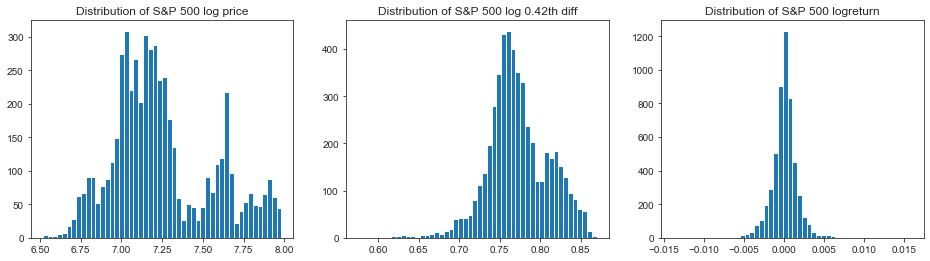

In [39]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.title(f'Distribution of S&P 500 log price')
plt.hist(X, bins=50)

plt.subplot(1, 3, 2)
plt.title(f'Distribution of S&P 500 log {order:.2f}th diff')
plt.hist(Xd_[window:], bins=50)

plt.subplot(1, 3, 3)
plt.title('Distribution of S&P 500 logreturn')
plt.hist(Xlr, bins=50)

plt.show()